In [114]:
%load_ext autoreload
%autoreload 2
import sys
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import preproc as pp


class COVID(object):
    def __init__(self):
        self.DATA_PATH = "../coronavirusdataset/"
        self.patient_route = pp.patient_route(self.DATA_PATH)
        self.case, self.group_map = pp.case(self.DATA_PATH)
        self.patient_info = pp.patient_info(self.DATA_PATH)
        self.patient_num = self.patient_info.shape[0]
        self.time = pp.time(self.DATA_PATH)
        self.region = pp.region(self.DATA_PATH)
        self.pre_proc()

    def pre_proc(self):
        # >>> patient_info:
        # fill missing value: infection_case, use etc
        self.patient_info["infection_case"].fillna("etc", inplace=True)
        # fill missing value: contact_number, use 0
        self.patient_info["contact_number"].fillna(0, inplace=True)
        # fill missing value: infected_by, use -1
        self.patient_info["infected_by"].fillna(-1, inplace=True)
        # fill missing value: sex, use ratio of all, generate a shuffle list then fill in the blank
        sex_count = dict(self.patient_info["sex"].value_counts())
        sex_num = sex_count["female"] + sex_count["male"]
        un_sex_male = int((self.patient_num - sex_num) * sex_count["male"] / sex_num)
        un_sex_female = int((self.patient_num - sex_num) - un_sex_male)
        fill_sex_list = ["male" for _ in range(0, un_sex_male)] + ["female" for _ in range(0, un_sex_female)]
        random.shuffle(fill_sex_list)
        self.patient_info.loc[self.patient_info["sex"].isnull(), "sex"] = fill_sex_list
        # fill missing value: age, use mean of province
        # # 1. fill bo
        all_age = self.patient_info.birth_year.mean()
        province_age = self.patient_info.groupby('province').birth_year.mean()
        province_age.loc[province_age.isnull()] = all_age
        fill_birth_list_idx = self.patient_info.loc[(self.patient_info["birth_year"].isnull()) & (self.patient_info["age"].isnull()), "birth_year"].index
        fill_birth_list = list(province_age[self.patient_info.loc[fill_birth_list_idx, "province"]])
        self.patient_info.loc[(self.patient_info["birth_year"].isnull()) & (self.patient_info["age"].isnull()), "birth_year"] = fill_birth_list
        # # 2. fill age
        fill_age_list_idx = self.patient_info.loc[self.patient_info["age"].isnull(), "age"].index
        cal_year_list = np.array(list(self.patient_info.loc[fill_age_list_idx, "birth_year"]))
        cal_year_list = (2020 - cal_year_list) / 10
        cal_year_list = cal_year_list.astype(int) * 10
        cal_year_list = [str(cal_year_list[i]) + 's' for i in range(cal_year_list.shape[0])]
        self.patient_info.loc[self.patient_info["age"].isnull(), "age"] = cal_year_list
        # fill birth again
        birth_mean = self.patient_info.groupby('age').birth_year.mean()
        fill_birth_list_idx = self.patient_info.loc[self.patient_info["birth_year"].isnull(), "birth_year"].index
        fill_birth_list = list(birth_mean[self.patient_info.loc[fill_birth_list_idx, "age"]])
        self.patient_info.loc[self.patient_info["birth_year"].isnull(), "birth_year"] = fill_birth_list
        # drop country
        self.patient_info.drop(columns=["country"], inplace=True)
        # fill missing value: city
        self.patient_info.loc[self.patient_info["city"] == "etc", "city"] = None
        self.patient_route["most_city"] = self.patient_route.groupby('patient_id').city.transform(
            lambda x: x.value_counts().index[0])
        fill_city_list_idx = self.patient_info.loc[self.patient_info["city"].isnull(), "city"].index
        route_most_city = self.patient_route.groupby('patient_id').most_city.max()
        fill_city_list_pid = self.patient_info.loc[fill_city_list_idx, "patient_id"]
        for idx, pid in fill_city_list_pid.iteritems():
            if pid in route_most_city.index:
                self.patient_info.loc[idx, "city"] = route_most_city[pid]
        self.patient_info["tmp"] = self.patient_info.groupby('province').city.transform(
            lambda x: x.value_counts().index[0])
        fill_city_list_idx = self.patient_info.loc[self.patient_info["city"].isnull(), "city"].index
        prov_most_city = self.patient_info.groupby('province').tmp.max()
        fill_city_list_pid = self.patient_info.loc[fill_city_list_idx, "patient_id"]
        for idx, pid in fill_city_list_pid.iteritems():
            # print(self.patient_info.loc[idx, "province"])
            self.patient_info.loc[idx, "city"] = prov_most_city[self.patient_info.loc[idx, "province"]]
        # fill last city and province
        ttp = self.patient_route.groupby("patient_id").last().reset_index()
        last_index = self.patient_info.loc[self.patient_info["patient_id"].isin(ttp["patient_id"])].index
        last_index = np.array(last_index)
        for idx in range(len(last_index)):
            self.patient_info.loc[self.patient_info.patient_id == ttp.loc[idx, "patient_id"], "last_city"] = ttp.loc[idx, "city"]
            self.patient_info.loc[self.patient_info.patient_id == ttp.loc[idx, "patient_id"], "last_province"] = ttp.loc[idx, "province"]
        null_last_idx = self.patient_info.loc[self.patient_info["last_city"].isnull()].index
        self.patient_info.loc[null_last_idx, "last_city"] = self.patient_info.loc[null_last_idx, "city"]
        self.patient_info.loc[null_last_idx, "last_province"] = self.patient_info.loc[null_last_idx, "province"]
        # fill disease
        self.patient_info["disease_b"] = 1
        self.patient_info.loc[self.patient_info["disease"].isnull(), "disease_b"] = 0
        self.patient_info["disease_b"].value_counts()
        # date formatting
        self.patient_info.loc[776, "symptom_onset_date"] = None
        self.patient_info["confirmed_date"] = pd.to_datetime(self.patient_info.confirmed_date)
        self.patient_info["symptom_onset_date"] = pd.to_datetime(self.patient_info.symptom_onset_date)
        self.patient_info["released_date"] = pd.to_datetime(self.patient_info.released_date)
        self.patient_info["deceased_date"] = pd.to_datetime(self.patient_info.deceased_date)
        self.time["date"] = pd.to_datetime(self.time.date)

        # >>> patient_route:
        self.patient_route["date"] = pd.to_datetime(self.patient_route.date)
        self.patient_info["start_date"] = pd.NaT
        for i, row in self.patient_info.iterrows():
            pid = row["patient_id"]
            dating = self.patient_route[self.patient_route["patient_id"] == pid]
            self.patient_info.loc[self.patient_info["patient_id"] == pid, "group"] = self.group_map[row["infection_case"]]
            if row["symptom_onset_date"] is not pd.NaT:
                if dating.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["symptom_onset_date"]
                    continue
                dating_b = dating[dating["date"] <= row["symptom_onset_date"]]
                if dating_b.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["symptom_onset_date"]
                    continue
                self.patient_info.loc[i, "start_date"] = dating_b.tail(1).reset_index().at[0, "date"]
            else:
                if dating.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["confirmed_date"]
                    continue
                dating_b = dating[dating["date"] <= row["confirmed_date"]]
                if dating_b.shape[0] == 0:
                    self.patient_info.loc[i, "start_date"] = row["confirmed_date"]
                    continue
                self.patient_info.loc[i, "start_date"] = dating_b.tail(1).reset_index().at[0, "date"]
        print(self.patient_info.isnull().sum())
        # fill missing value: sym date
        # self.patient_info.to_excel("./tmp/patient_info.xlsx")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
covid_model = COVID()

patient_id               0
sex                      0
birth_year               0
age                      0
province                 0
city                     0
infection_case           0
infected_by              0
contact_number           0
disease               3110
symptom_onset_date    2683
confirmed_date           0
released_date         2147
deceased_date         3072
state                    0
group                    0
tmp                      0
last_city                0
last_province            0
disease_b                0
start_date               0
dtype: int64


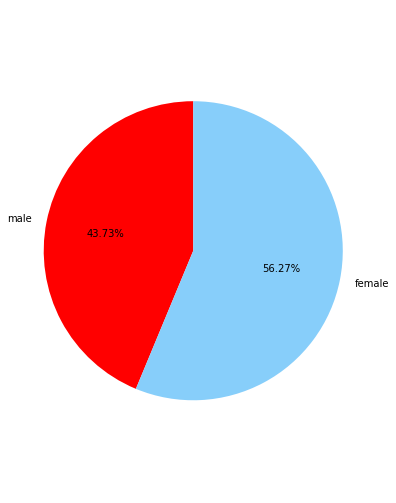

In [116]:
# plot: sex
sex_stat = covid_model.patient_info["sex"].value_counts()
plt.rcParams['font.family'] = ['DejaVu Sans']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(6,9)) #调节图形大小
labels = [u'male',u'female'] #定义标签
sizes = [sex_stat["male"],sex_stat["female"]] #每块值
colors = ['red','lightskyblue'] #每块颜色定义
explode = (0,0) #将某一块分割出来，值越大分割出的间隙越大
patches,text1,text2 = plt.pie(sizes,
                      explode=explode,
                      labels=labels,
                      colors=colors,
                      autopct = '%3.2f%%', #数值保留固定小数位
                      shadow = False, #无阴影设置
                      startangle =90, #逆时针起始角度设置
                      pctdistance = 0.6) #数值距圆心半径倍数距离
#patches饼图的返回值，texts1饼图外label的文本，texts2饼图内部的文本
# x，y轴刻度设置一致，保证饼图为圆形
plt.axis('equal')
plt.show()

In [117]:
import folium
import pandas as pd
from folium import plugins

# define the kr map
loc = [36.4268093, 126.5512681]
kr_map = folium.Map(location=loc, zoom_start=7)

# add all patient
incidents = plugins.MarkerCluster().add_to(kr_map)
for lat, lng, label, in zip(covid_model.patient_route.latitude, covid_model.patient_route.longitude, covid_model.patient_route.province):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# display kr map
kr_map

In [118]:
# define the kr map
loc = [36.4268093, 126.5512681]
kr_map = folium.Map(location=loc, zoom_start=7)

# add heatmap
heatdata = covid_model.patient_route[['latitude','longitude']].values.tolist()
plugins.HeatMap(heatdata).add_to(kr_map)
kr_map

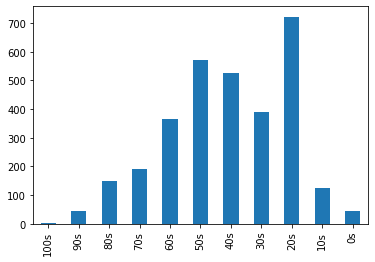

In [119]:
#covid_model.patient_info['age'].plot.hist()
# covid_model.patient_info['age'].value_counts
count = covid_model.patient_info["age"].value_counts()
bar = ['100s','90s','80s','70s','60s','50s','40s','30s','20s','10s','0s']
# plot.bar(y=['100s','90s','80s','70s','60s','50s','40s','30s','20s','10s','0s'])
count[bar].plot.bar()

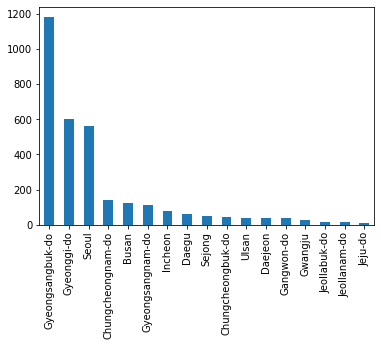

In [120]:
covid_model.patient_info["province"].value_counts().plot.bar()

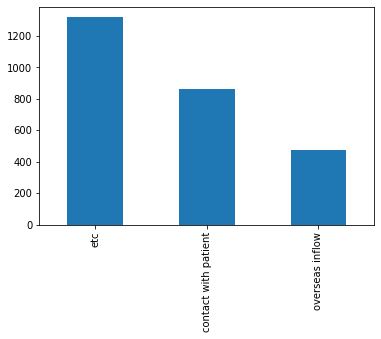

In [121]:
# other infection case
covid_model.patient_info["infection_case"].value_counts()[:3].plot.bar()


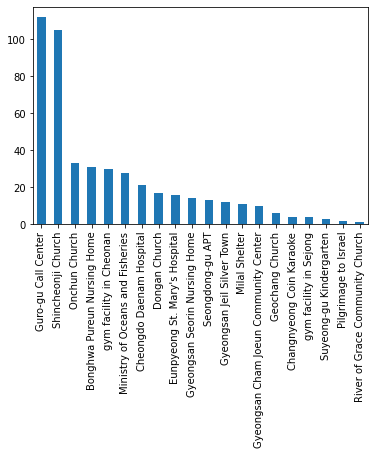

In [122]:
# home infection case
covid_model.patient_info["infection_case"].value_counts()[3:].plot.bar()

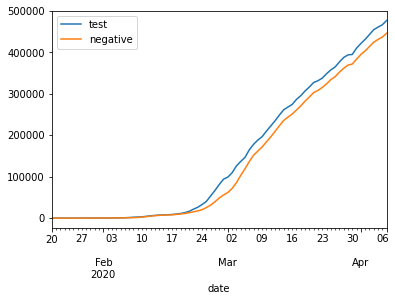

In [123]:
if "date" in covid_model.time.columns:
    # datetime_index = pd.DatetimeIndex(covid_model.time.date.values)
    covid_model.time = covid_model.time.set_index("date")
    # covid_model.time = covid_model.time.set_index(datetime_index)
    covid_model.time[["test", "negative"]].plot.line()
else:
    covid_model.time[["test", "negative"]].plot.line()


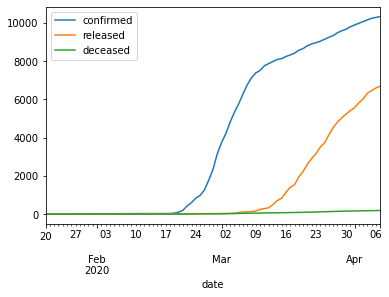

In [124]:
if "date" in covid_model.time.columns:
    # datetime_index = pd.DatetimeIndex(covid_model.time.date.values)
    covid_model.time = covid_model.time.set_index("date")
    # covid_model.time = covid_model.time.set_index(datetime_index)
    covid_model.time[["confirmed", "released", "deceased"]].plot.line()
else:
    covid_model.time[["confirmed", "released", "deceased"]].plot.line()

[[1990.19113066]
 [1957.21804833]]


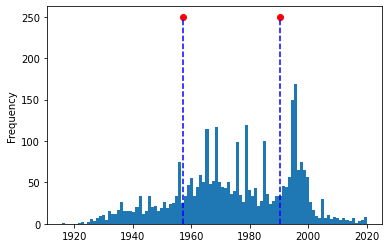

In [125]:
# task 6
from sklearn.cluster import KMeans
kkk = 2
birth = covid_model.patient_info["birth_year"]
birth_np = np.array(birth)
birth_np = birth_np.reshape(-1, 1)
km = KMeans(n_clusters=kkk)
km.fit(birth_np)
cent = km.cluster_centers_
print(cent)
plt.figure()
ppt = covid_model.patient_info["birth_year"].plot.hist(bins=100)
plt.scatter(km.cluster_centers_, [250 for _ in range(kkk)], c='r')
for i in range(kkk):
    plt.plot([cent[i], cent[i]], [0, 250], c='b', linestyle='--')

In [126]:
# task 4 line route in 
# define the kr map
from sklearn.cluster import KMeans
kkk = 10

loc = [36.4268093, 126.5512681]
kr_map = folium.Map(location=loc, zoom_start=7)

for k0, group in covid_model.patient_route.groupby("patient_id"):
    rt = list(zip(group["latitude"], group["longitude"]))
    folium.PolyLine(rt).add_to(kr_map)

pos = covid_model.patient_route[["latitude", "longitude"]]
km = KMeans(n_clusters=kkk)
km.fit(pos)
cent = km.cluster_centers_
for point in range(0, kkk):
    folium.Marker(cent[point]).add_to(kr_map)

kr_map

In [127]:
def folium_map_to_png(filename, dest_folder_name):
    delay = 5
    input_dir = 'file://{path}/{dirname}/{mapfile}'.format(path=os.getcwd(),dirname="tmp/route_gif",mapfile=filename)
    #Open a browser window...
    #browser = webdriver.Firefox(executable_path=os.path.abspath("geckodriver"))
    browser = webdriver.Chrome(executable_path=os.path.abspath("/usr/local/bin/chromedriver"))
    #..that displays the map...
    browser.get(input_dir)
    #Give the map tiles some time to load
    time.sleep(delay)
    #Grab the screenshot
    curr_dir = os.getcwd()
    src_folder = curr_dir + dest_folder_name
    if not os.path.exists(src_folder):
        os.mkdir(src_folder)
    src_subfolder = src_folder + filename.rpartition("_")[0] + "/"
    if not os.path.exists(src_subfolder):
        os.mkdir(src_subfolder)
    pic = src_subfolder + filename.split(".")[0] + ".png"
    browser.save_screenshot(pic)
    #Close the browser
    browser.quit()

In [128]:
import datetime
import time
import imageio
import os,sys
from selenium import webdriver
from pprint import pprint
import glob
e=sys.exit
kkk = 10
swc = False
if swc:
    print(covid_model.patient_route["date"].max())
    begin = datetime.date(2020,2,9)
    end = datetime.date(2020,3,30)
    delta = datetime.timedelta(days=1)
    day = begin
    dest_folder = "tmp/route_gif/"
    while day <= end:
        loc = [35.8268093, 127.8512681]
        kr_map = folium.Map(location=loc, zoom_start=8)
        ds = day.strftime("%Y-%m-%d")
        c_day_route = covid_model.patient_route.loc[covid_model.patient_route["date"] <= ds]
        if c_day_route.shape[0]:
            for k0, group in c_day_route.groupby("patient_id"):
                rt = list(zip(group["latitude"], group["longitude"]))
                folium.PolyLine(rt, weight=1).add_to(kr_map)
        pos = c_day_route[["latitude", "longitude"]]
        km = KMeans(n_clusters=kkk)
        km.fit(pos)
        cent = km.cluster_centers_
        for point in range(0, kkk):
            folium.Marker(cent[point]).add_to(kr_map)
        filename = ds+".html"
        kr_map.save(dest_folder+filename)
        folium_map_to_png(filename, "/" + dest_folder)
        # display(kr_map)
        # time.sleep(4)
        day += delta

In [129]:
swc = False
if swc:
    images = []
    begin = datetime.date(2020,1,24)
    end = datetime.date(2020,3,30)
    delta = datetime.timedelta(days=1)
    day = begin
    dest_folder = "tmp/route_gif/"
    duration = 10
    while day <= end:
        filename = dest_folder + day.strftime("%Y-%m-%d") + ".png"
        images.append(imageio.imread(filename))
        day += delta
    output_file = '1Gif.gif'
    imageio.mimsave(dest_folder + output_file, images, duration=1/15)


In [131]:
# task 3 risk levels of the cities
cr = covid_model.region.copy()
cr["count"] = 0
cr["released"] = 0
cr["isolated"] = 0
cr["deceased"] = 0

cnt = covid_model.patient_info.groupby(["province", "city"]).agg({'patient_id': ['count']})
cnt.columns = ['count']
cnt["released"] = 0
cnt["isolated"] = 0
cnt["deceased"] = 0
cnt = cnt.reset_index()
nc = pd.DataFrame(covid_model.patient_info.groupby(["province", "city"])["state"].value_counts())
nc.columns = ['count']
nc = nc.reset_index()
for row in nc.itertuples():
    cnt.loc[(cnt["province"]==getattr(row, "province"))&(cnt["city"]==getattr(row, "city")), getattr(row, "state")] = getattr(row, "count")

ccc = 0
for row in cnt.itertuples():
    if cr.loc[(cr["province"]==getattr(row, "province"))&(cr["city"]==getattr(row, "city"))].shape[0] == 0:
        continue
    cr.loc[(cr["province"]==getattr(row, "province"))&(cr["city"]==getattr(row, "city")), "count"] = getattr(row, "count")
    covid_model.region.loc[(covid_model.region["province"]==getattr(row, "province"))&(cr["city"]==getattr(row, "city")), "released"] = getattr(row, "released")
    cr.loc[(cr["province"]==getattr(row, "province"))&(cr["city"]==getattr(row, "city")), "isolated"] = getattr(row, "isolated")
    cr.loc[(cr["province"]==getattr(row, "province"))&(cr["city"]==getattr(row, "city")), "deceased"] = getattr(row, "deceased")

cr

province          city   latitude   longitude  \
0               Seoul         Seoul  37.566953  126.977977   
1               Seoul    Gangnam-gu  37.518421  127.047222   
2               Seoul   Gangdong-gu  37.530492  127.123837   
3               Seoul    Gangbuk-gu  37.639938  127.025508   
4               Seoul    Gangseo-gu  37.551166  126.849506   
..                ...           ...        ...         ...   
239  Gyeongsangnam-do     Haman-gun  35.272481  128.406540   
240  Gyeongsangnam-do   Hamyang-gun  35.520541  127.725177   
241  Gyeongsangnam-do  Hapcheon-gun  35.566702  128.165870   
242           Jeju-do       Jeju-do  33.488936  126.500423   
243             Korea         Korea  37.566953  126.977977   

     elementary_school_count  kindergarten_count  university_count  \
0                        607                 830                48   
1                         33                  38                 0   
2                         27                  32                 0   
3                         14                  21                 0   
4                         36                  56                 1   
..                       ...                 ...               ...   
239                       16                  20                 0   
240                       13                  12                 0   
241                       17                  15                 0   
242                      113                 123                 4   
243                     6087                8837               340   

     academy_ratio  elderly_population_ratio  elderly_alone_ratio  \
0             1.44                     15.38                  5.8   
1             4.18                     13.17                  4.3   
2             1.54                     14.55                  5.4   
3             0.67                     19.49                  8.5   
4             1.17                     14.39                  5.7   
..             ...                       ...                  ...   
239           1.19                     23.74                 14.7   
240           1.01                     32.65                 20.9   
241           0.71                     38.44                 24.7   
242           1.53                     15.10                  6.4   
243           1.56                     15.67                  7.2   

     nursing_home_count  count  released  isolated  deceased  
0                 22739      0         0         0         0  
1                  3088     69         0        60         0  
2                  1023     14         0        10         0  
3                   628      5         0         5         0  
4                  1080     24         0        22         0  
..                  ...    ...       ...       ...       ...  
239                  94      1         0         1         0  
240                  83      1         0         0         0  
241                  96      8         0         2         0  
242                1245      9         0         5         0  
243               94865      0         0         0         0  

[244 rows x 15 columns]